### Data & libraries import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score

from matplotlib.colors import TwoSlopeNorm
from sklearn.decomposition import PCA

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)

In [3]:
df_iphone = pd.read_csv("data/iphone_kmc.csv")
summary_iphone = df_iphone.groupby(["cluster", "price_tier"]).agg({
    "price.value": ['count', 'mean', 'min', "median", 'max']})
print(summary_iphone)
median_iphone = df_iphone["price.value"].median()
df_iphone["is_high_price"] = df_iphone["price.value"] > median_iphone

df_soccer = pd.read_csv("data/soccer_kmc.csv")
summary_soccer = df_soccer.groupby(["cluster", "price_tier"]).agg({
    "price.value": ['count', 'mean', 'min', "median", 'max']})
print(summary_soccer)
median_soccer = df_soccer["price.value"].median()
df_soccer["is_high_price"] = df_soccer["price.value"] > median_soccer

df_microwaves = pd.read_csv("data/microwave_kmc.csv")
summary_microwave = df_microwaves.groupby(["cluster", "price_tier"]).agg({
    "price_value": ['count', 'mean', 'min', "median", 'max']})
print(summary_microwave)
median_microwave = df_microwaves["price_value"].median()
df_microwaves["is_high_price"] = df_microwaves["price_value"] > median_microwave

df_lego = pd.read_csv("data/lego_kmc.csv")
summary_lego = df_lego.groupby(["cluster", "price_tier"]).agg({
    "price_value": ['count', 'mean', 'min', "median", 'max']})
print(summary_lego)
median_lego = df_lego["price_value"].median()
df_lego["is_high_price"] = df_lego["price_value"] > median_lego

                   price.value                                      
                         count        mean     min   median      max
cluster price_tier                                                  
0       medium             166  536.551687  446.99  537.975   650.00
1       high                96  848.694583  650.00  776.995  1449.99
2       low                124  352.649919  215.00  349.915   439.99
                   price.value                                 
                         count       mean    min median     max
cluster price_tier                                             
0       high               250  83.140840  60.00  73.90  299.99
1       low                336  27.519554   5.94  28.98   38.50
2       medium             414  49.747512  38.88  49.99   60.00
                   price_value                                     
                         count        mean     min  median      max
cluster price_tier                                                

### iPhone

#### price classification

In [4]:
num_features_iphone = ["seller.feedbackPercentage", "seller.feedbackScore", "days_listed",  "seller_item_count",
"additional_image_count", "title_length", "model_number"]
response = "is_high_price"

X_train_iphone, X_test_iphone, y_train_iphone, y_test_iphone = train_test_split(df_iphone[num_features_iphone], df_iphone[response],
                                                               test_size=0.20, random_state=1216)

sc = StandardScaler()
X_train_scaled_iphone = sc.fit_transform(X_train_iphone)
X_test_scaled_iphone = sc.transform(X_test_iphone)

y_train_iphone = y_train_iphone.astype(int)
y_test_iphone = y_test_iphone.astype(int)


In [5]:
params_grid = [{'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['linear']},
               {'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['rbf'], 'gamma': ['scale', 0.1, 1]},
               {'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['poly'], 'degree': [2, 3, 4], 
                'gamma': ['scale', 0.1, 1], 'coef0': [0, 1]}]

classifier_iphone = SVC(probability=True)
grid_search_iphone = GridSearchCV(estimator = classifier_iphone,
                           param_grid = params_grid,
                           scoring = 'accuracy', 
                           cv = 10,
                           n_jobs = -1)

grid_search_iphone.fit(X_train_scaled_iphone, y_train_iphone)

best_acc = grid_search_iphone.best_score_
best_parameters = grid_search_iphone.best_params_
print('Best CV Accuracy:', best_acc)
print('Best CV Parameters:', best_parameters)

results = pd.DataFrame(grid_search_iphone.cv_results_)
results_sorted = results.sort_values(by="mean_test_score", ascending=False)
print(results_sorted[["params", "mean_test_score"]].head(5))
results_sorted = results_sorted[["params", "mean_test_score"]].head(5)
results_sorted = results_sorted.rename(columns={
    "params": "SVM Parameters",
    "mean_test_score": "Mean CV Score"
})

html_table = results_sorted.to_html(index=False, escape=False)
print(html_table)

Best CV Accuracy: 0.7596774193548387
Best CV Parameters: {'C': 10, 'kernel': 'linear'}
                                               params  mean_test_score
4                       {'C': 10, 'kernel': 'linear'}         0.759677
0                      {'C': 0.1, 'kernel': 'linear'}         0.759570
30  {'C': 0.1, 'coef0': 1, 'degree': 2, 'gamma': 0...         0.750323
29  {'C': 0.1, 'coef0': 1, 'degree': 2, 'gamma': '...         0.750323
3                        {'C': 5, 'kernel': 'linear'}         0.750000
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>SVM Parameters</th>
      <th>Mean CV Score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>{'C': 10, 'kernel': 'linear'}</td>
      <td>0.759677</td>
    </tr>
    <tr>
      <td>{'C': 0.1, 'kernel': 'linear'}</td>
      <td>0.759570</td>
    </tr>
    <tr>
      <td>{'C': 0.1, 'coef0': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}</td>
      <td>0.750323</td>
    </tr>
    <tr>
  

Test accuracy
0.7564102564102564


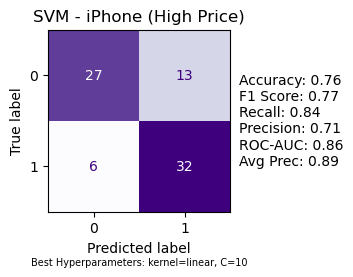

Predictions: (array([0, 1]), array([33, 45]))


In [6]:
best_model_iphone = grid_search_iphone.best_estimator_
preds_best_iphone = best_model_iphone.predict(X_test_scaled_iphone)
y_proba = best_model_iphone.predict_proba(X_test_scaled_iphone)[:,1]

accuracy = accuracy_score(y_test_iphone, preds_best_iphone)
print("Test accuracy")
print(accuracy)

accuracy = accuracy_score(y_test_iphone, preds_best_iphone)
f1 = f1_score(y_test_iphone,  preds_best_iphone)
recall = recall_score(y_test_iphone,  preds_best_iphone)
prec = precision_score(y_test_iphone, preds_best_iphone)
roc_auc = roc_auc_score(y_test_iphone, y_proba)
avg_prec = average_precision_score(y_test_iphone, y_proba)

cm_iphone = confusion_matrix(y_test_iphone,  preds_best_iphone)
fig, ax = plt.subplots(figsize=(5,3))
disp_iphone = ConfusionMatrixDisplay(confusion_matrix=cm_iphone, display_labels=best_model_iphone.classes_)
disp_iphone = disp_iphone.plot(ax=ax, cmap="Purples", colorbar=False)
disp_iphone.ax_.set_title('SVM - iPhone (High Price)')

textstr = f'Accuracy: {accuracy:.2f}\nF1 Score: {f1:.2f}\nRecall: {recall:.2f}\nPrecision: {prec:.2f}\nROC-AUC: {roc_auc:.2f}\nAvg Prec: {avg_prec:.2f}'
ax.text(1.05, 0.5, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='center')

params = [f'kernel={best_model_iphone.kernel}', f'C={best_model_iphone.C}']
if hasattr(best_model_iphone, "degree") and best_model_iphone.kernel == "poly":
    params.append(f'degree={best_model_iphone.degree}')
if hasattr(best_model_iphone, "gamma") and best_model_iphone.kernel in ["rbf", "poly", "sigmoid"]:
    params.append(f'gamma={best_model_iphone.gamma}')
if hasattr(best_model_iphone, "coef0") and best_model_iphone.kernel in ["poly", "sigmoid"]:
    params.append(f'coef0={best_model_iphone.coef0}')
params_str = "Best Hyperparameters: " + ", ".join(params)
ax.text(0.5, -0.25, params_str, transform=ax.transAxes,
        fontsize=7, ha='center', va='top')

plt.tight_layout()
plt.savefig("images/4/cm_svm_iphone.png", dpi=300, bbox_inches='tight')
plt.show()

print("Predictions:", np.unique(preds_best_iphone, return_counts=True))

In [7]:
print("True y")
print(np.unique(y_test_iphone, return_counts=True), "\n")
print("Predicted y")
print(np.unique(preds_best_iphone, return_counts=True), "\n")

true_labels, true_counts = np.unique(y_test_iphone, return_counts=True)
pred_labels, pred_counts = np.unique(preds_best_iphone, return_counts=True)

df_counts = pd.DataFrame({
    "True Label": pd.Series(true_counts, index=true_labels),
    "Predicted Label": pd.Series(pred_counts, index=pred_labels)
}).fillna(0).astype(int)

html_table = df_counts.to_html(border=0, index=True)
print(html_table)

True y
(array([0, 1]), array([40, 38])) 

Predicted y
(array([0, 1]), array([33, 45])) 

<table class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>True Label</th>
      <th>Predicted Label</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>40</td>
      <td>33</td>
    </tr>
    <tr>
      <th>1</th>
      <td>38</td>
      <td>45</td>
    </tr>
  </tbody>
</table>


In [8]:
print("Number of support vectors for each class:", best_model_iphone.n_support_)
print("Total support vectors:", best_model_iphone.support_vectors_.shape[0])

Number of support vectors for each class: [91 82]
Total support vectors: 173


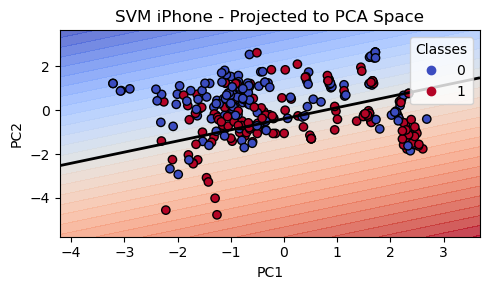

In [9]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled_iphone)
X_test_pca = pca.transform(X_test_scaled_iphone)

def plot_svm_decision_boundary_pca(model, X_original, X_pca, y, pca, features, title, image="image"):
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    
    grid_pca = np.c_[xx.ravel(), yy.ravel()]
    grid_full = pca.inverse_transform(grid_pca) 
    Z = model.decision_function(grid_full).reshape(xx.shape)

    divnorm = TwoSlopeNorm(vmin=Z.min(), vcenter=0, vmax=Z.max())

    plt.figure(figsize=(5, 3))
    contour = plt.contourf(xx, yy, Z, levels=30, cmap=plt.cm.coolwarm, norm=divnorm, alpha=0.8)
    plt.contour(xx, yy, Z, levels=[0], colors='k', linewidths=2)  # decision boundary
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title(title)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.tight_layout()
    plt.savefig(f"images/4/{image}", dpi=300, bbox_inches='tight')
    plt.show()

plot_svm_decision_boundary_pca(best_model_iphone, 
                               X_train_scaled_iphone, 
                               X_train_pca, 
                               y_train_iphone.values, 
                               pca, 
                               ['PC1', 'PC2'], 
                               "SVM iPhone - Projected to PCA Space", 
                               "svm_boundary_iphone")

In [10]:
if best_model_iphone.kernel == 'linear':
    coefs = best_model_iphone.coef_.flatten()
    feature_importance = pd.Series(coefs, index=num_features_iphone)
    feature_importance = feature_importance.abs().sort_values(ascending=False)
    print("Feature importance (absolute coefficient values):")
    print(feature_importance)
else:
    print("Model is not linear. Coefficients are not directly available.")

from sklearn.inspection import permutation_importance
result = permutation_importance(best_model_iphone, X_test_scaled_iphone, y_test_iphone, 
                                n_repeats=10, random_state=1216, scoring='accuracy')
importance_means = result.importances_mean
importance_std = result.importances_std

for i, col in enumerate(num_features_iphone):
    print(f"{col}: Mean importance = {importance_means[i]:.4f}, Std = {importance_std[i]:.4f}")


Feature importance (absolute coefficient values):
model_number                 0.879913
seller_item_count            0.001494
additional_image_count       0.000842
seller.feedbackScore         0.000447
days_listed                  0.000396
title_length                 0.000325
seller.feedbackPercentage    0.000049
dtype: float64
seller.feedbackPercentage: Mean importance = 0.0000, Std = 0.0000
seller.feedbackScore: Mean importance = -0.0077, Std = 0.0143
days_listed: Mean importance = -0.0295, Std = 0.0100
seller_item_count: Mean importance = 0.0167, Std = 0.0304
additional_image_count: Mean importance = 0.0026, Std = 0.0112
title_length: Mean importance = -0.0154, Std = 0.0096
model_number: Mean importance = 0.2962, Std = 0.0327


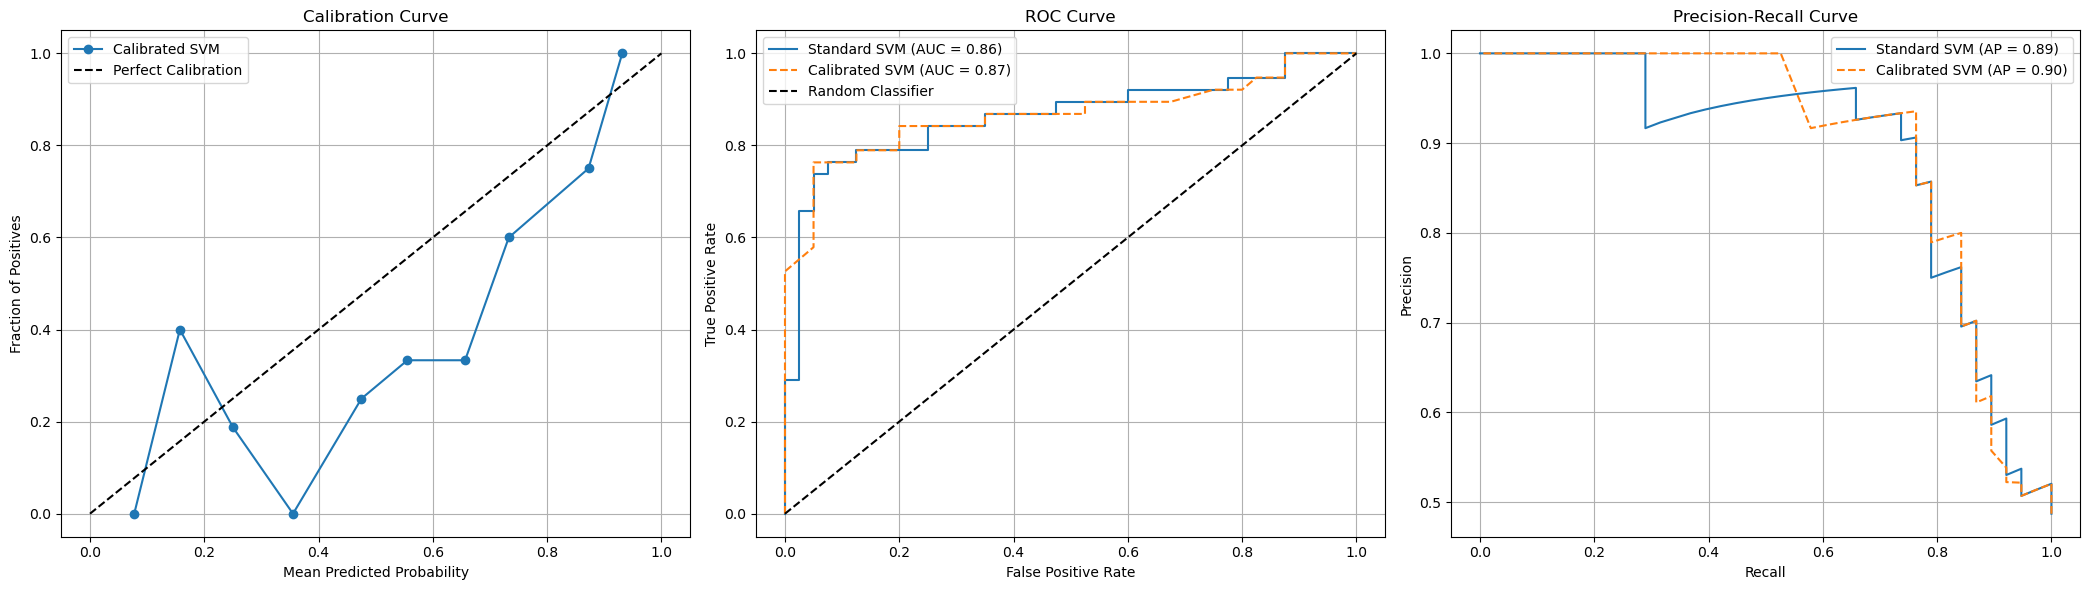

In [11]:
# Calibrate the best model
calibrated_model_iphone = CalibratedClassifierCV(best_model_iphone, method='isotonic', cv=5)
calibrated_model_iphone.fit(X_train_scaled_iphone, y_train_iphone)

# Get decision function and predicted probabilities
y_scores_std = best_model_iphone.decision_function(X_test_scaled_iphone)
y_probs_cal = calibrated_model_iphone.predict_proba(X_test_scaled_iphone)[:, 1]

# === CALIBRATION CURVE ===
prob_true, prob_pred = calibration_curve(y_test_iphone, y_probs_cal, n_bins=10)

# === ROC CURVE ===
auc_std = roc_auc_score(y_test_iphone, y_scores_std)
auc_cal = roc_auc_score(y_test_iphone, y_probs_cal)
fpr_std, tpr_std, _ = roc_curve(y_test_iphone, y_scores_std)
fpr_cal, tpr_cal, _ = roc_curve(y_test_iphone, y_probs_cal)

# === PRECISION-RECALL CURVE ===
precision_std, recall_std, _ = precision_recall_curve(y_test_iphone, y_scores_std)
avg_precision_std = average_precision_score(y_test_iphone, y_scores_std)

precision_cal, recall_cal, _ = precision_recall_curve(y_test_iphone, y_probs_cal)
avg_precision_cal = average_precision_score(y_test_iphone, y_probs_cal)

# === PLOTTING ===
fig, axs = plt.subplots(1, 3, figsize=(21, 6))

# 1. Calibration Curve
axs[0].plot(prob_pred, prob_true, marker='o', label="Calibrated SVM")
axs[0].plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
axs[0].set_xlabel("Mean Predicted Probability")
axs[0].set_ylabel("Fraction of Positives")
axs[0].set_title("Calibration Curve")
axs[0].legend()
axs[0].grid(True)

# 2. ROC Curve
axs[1].plot(fpr_std, tpr_std, label=f"Standard SVM (AUC = {auc_std:.2f})")
axs[1].plot(fpr_cal, tpr_cal, label=f"Calibrated SVM (AUC = {auc_cal:.2f})", linestyle='--')
axs[1].plot([0, 1], [0, 1], 'k--', label="Random Classifier")
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")
axs[1].set_title("ROC Curve")
axs[1].legend()
axs[1].grid(True)

# 3. Precision-Recall Curve
axs[2].plot(recall_std, precision_std, label=f"Standard SVM (AP = {avg_precision_std:.2f})")
axs[2].plot(recall_cal, precision_cal, label=f"Calibrated SVM (AP = {avg_precision_cal:.2f})", linestyle='--')
axs[2].set_xlabel("Recall")
axs[2].set_ylabel("Precision")
axs[2].set_title("Precision-Recall Curve")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.savefig("images/4/calibration_roc_pr_iphone.png", dpi=300, bbox_inches='tight')
plt.show()

Best threshold for F1: 0.62
              precision    recall  f1-score   support

           0       0.81      0.88      0.84        40
           1       0.86      0.79      0.82        38

    accuracy                           0.83        78
   macro avg       0.84      0.83      0.83        78
weighted avg       0.83      0.83      0.83        78

[[35  5]
 [ 8 30]]


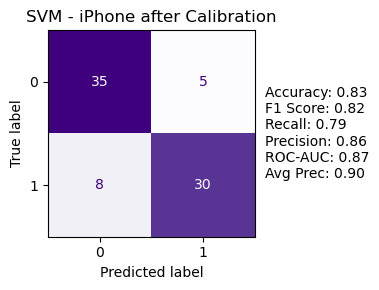

Predictions: (array([0, 1]), array([43, 35]))


In [12]:
probs = calibrated_model_iphone.predict_proba(X_test_scaled_iphone)[:, 1]
thresholds = np.linspace(0, 1, 100)
f1_scores = [f1_score(y_test_iphone, probs > t) for t in thresholds]
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"Best threshold for F1: {best_thresh:.2f}")

y_pred_adjusted = (probs > best_thresh).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test_iphone, y_pred_adjusted))
print(confusion_matrix(y_test_iphone, y_pred_adjusted))

accuracy = accuracy_score(y_test_iphone, y_pred_adjusted)
f1 = f1_score(y_test_iphone,  y_pred_adjusted)
recall = recall_score(y_test_iphone,  y_pred_adjusted)
prec = precision_score(y_test_iphone, y_pred_adjusted)
roc_auc = roc_auc_score(y_test_iphone, probs)
avg_prec = average_precision_score(y_test_iphone, probs)

cm_iphone = confusion_matrix(y_test_iphone,  y_pred_adjusted)
fig, ax = plt.subplots(figsize=(5,3))
disp_iphone = ConfusionMatrixDisplay(confusion_matrix=cm_iphone, display_labels=calibrated_model_iphone.classes_)
disp_iphone = disp_iphone.plot(ax=ax, cmap="Purples", colorbar=False)
disp_iphone.ax_.set_title('SVM - iPhone after Calibration')
textstr = f'Accuracy: {accuracy:.2f}\nF1 Score: {f1:.2f}\nRecall: {recall:.2f}\nPrecision: {prec:.2f}\nROC-AUC: {roc_auc:.2f}\nAvg Prec: {avg_prec:.2f}'

ax.text(1.05, 0.5, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='center')
plt.tight_layout()
plt.savefig("images/4/cm_svm_iphone2.png", dpi=300, bbox_inches='tight')
plt.show()

print("Predictions:", np.unique(y_pred_adjusted, return_counts=True))


#### priority listing classification

In [13]:
num_features_iphone = ["seller.feedbackPercentage", "seller.feedbackScore", "days_listed",  "seller_item_count",
"additional_image_count", "title_length", "model_number", "price.value"]
response = "priorityListing" #"topRatedBuyingExperience" 

X_train_iphone, X_test_iphone, y_train_iphone, y_test_iphone = train_test_split(df_iphone[num_features_iphone], df_iphone[response],
                                                               test_size=0.20, random_state=1216)

print(np.unique(y_train_iphone, return_counts=True))
print(np.unique(y_test_iphone, return_counts=True))

sc = StandardScaler()
X_train_scaled_iphone = sc.fit_transform(X_train_iphone)
X_test_scaled_iphone = sc.transform(X_test_iphone)

y_train_iphone = y_train_iphone.astype(int)
y_test_iphone = y_test_iphone.astype(int)

print(np.unique(y_train_iphone, return_counts=True))

(array([False,  True]), array([229,  79]))
(array([False,  True]), array([61, 17]))
(array([0, 1]), array([229,  79]))


In [14]:
params_grid = [{'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['linear']},
               {'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['rbf'], 'gamma': ['scale', 0.1, 1]},
               {'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['poly'], 'degree': [2, 3, 4], 
                'gamma': ['scale', 0.1, 1], 'coef0': [0, 1]}]

classifier_iphone = SVC(class_weight="balanced", probability=True)
scoring = "recall"
grid_search_iphone = GridSearchCV(estimator = classifier_iphone,
                           param_grid = params_grid,
                           scoring = scoring, 
                           cv = 10,
                           n_jobs = -1)

grid_search_iphone.fit(X_train_scaled_iphone, y_train_iphone)

best_scoring = grid_search_iphone.best_score_
best_parameters = grid_search_iphone.best_params_
print("Best Scoring:", best_scoring)
print('Best CV Parameters:', best_parameters)

results = pd.DataFrame(grid_search_iphone.cv_results_)
results_sorted = results.sort_values(by="mean_test_score", ascending=False)
print(results_sorted[["params", "mean_test_score"]].head(5))

best_model_iphone = grid_search_iphone.best_estimator_

Best Scoring: 0.7732142857142856
Best CV Parameters: {'C': 10, 'coef0': 0, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'}
                                               params  mean_test_score
98  {'C': 10, 'coef0': 0, 'degree': 4, 'gamma': 's...         0.773214
80  {'C': 5, 'coef0': 0, 'degree': 4, 'gamma': 'sc...         0.748214
99  {'C': 10, 'coef0': 0, 'degree': 4, 'gamma': 0....         0.708929
53  {'C': 0.5, 'coef0': 1, 'degree': 4, 'gamma': '...         0.708929
11        {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}         0.708929


Test Accuracy: 0.5897435897435898
Test F1 0.4074074074074074
Test Recall 0.6470588235294118
Test Precision 0.2972972972972973
Test ROC AUC: 0.7396335583413693
Test Average Precision (AP): 0.45440600626481287
              precision    recall  f1-score   support

           0       0.85      0.57      0.69        61
           1       0.30      0.65      0.41        17

    accuracy                           0.59        78
   macro avg       0.58      0.61      0.55        78
weighted avg       0.73      0.59      0.63        78

[[35 26]
 [ 6 11]]


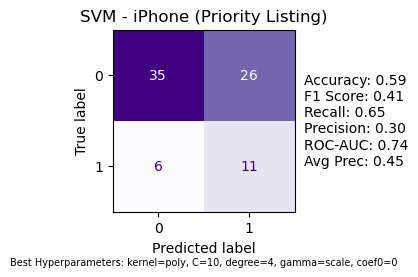

Predictions: (array([0, 1]), array([41, 37]))


In [15]:
y_pred = best_model_iphone.predict(X_test_scaled_iphone)
y_proba = best_model_iphone.predict_proba(X_test_scaled_iphone)[:,1]

accuracy = accuracy_score(y_test_iphone, y_pred)
f1 = f1_score(y_test_iphone,  y_pred)
recall = recall_score(y_test_iphone,  y_pred)
prec = precision_score(y_test_iphone, y_pred)
roc_auc = roc_auc_score(y_test_iphone, y_proba)
avg_prec = average_precision_score(y_test_iphone, y_proba)

print("Test Accuracy:", accuracy)
print("Test F1", f1)
print("Test Recall", recall)
print("Test Precision", prec)
print("Test ROC AUC:", roc_auc)
print("Test Average Precision (AP):", avg_prec)

print(classification_report(y_test_iphone, y_pred))
print(confusion_matrix(y_test_iphone, y_pred))

cm_iphone = confusion_matrix(y_test_iphone, y_pred)
fig, ax = plt.subplots(figsize=(5,3))
disp_iphone = ConfusionMatrixDisplay(confusion_matrix=cm_iphone, display_labels=best_model_iphone.classes_)
disp_iphone = disp_iphone.plot(ax=ax, cmap="Purples", colorbar=False)
disp_iphone.ax_.set_title('SVM - iPhone (Priority Listing)')

textstr = f'Accuracy: {accuracy:.2f}\nF1 Score: {f1:.2f}\nRecall: {recall:.2f}\nPrecision: {prec:.2f}\nROC-AUC: {roc_auc:.2f}\nAvg Prec: {avg_prec:.2f}'
ax.text(1.05, 0.5, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='center')

params = [f'kernel={best_model_iphone.kernel}', f'C={best_model_iphone.C}']
if hasattr(best_model_iphone, "degree") and best_model_iphone.kernel == "poly":
    params.append(f'degree={best_model_iphone.degree}')
if hasattr(best_model_iphone, "gamma") and best_model_iphone.kernel in ["rbf", "poly", "sigmoid"]:
    params.append(f'gamma={best_model_iphone.gamma}')
if hasattr(best_model_iphone, "coef0") and best_model_iphone.kernel in ["poly", "sigmoid"]:
    params.append(f'coef0={best_model_iphone.coef0}')
params_str = "Best Hyperparameters: " + ", ".join(params)
ax.text(0.5, -0.25, params_str, transform=ax.transAxes,
        fontsize=7, ha='center', va='top')

plt.tight_layout()
plt.savefig("images/4/cm_svm_iphone3.png", dpi=300, bbox_inches='tight')
plt.show()
print("Predictions:", np.unique(y_pred, return_counts=True))


Best threshold for F1: 0.47
Test Accuracy: 0.8205128205128205
Test F1 0.5333333333333333
Test Recall 0.47058823529411764
Test ROC AUC: 0.7468659594985535
Test Average Precision (AP): 0.49463065517632077
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        61
           1       0.62      0.47      0.53        17

    accuracy                           0.82        78
   macro avg       0.74      0.69      0.71        78
weighted avg       0.81      0.82      0.81        78

[[56  5]
 [ 9  8]]


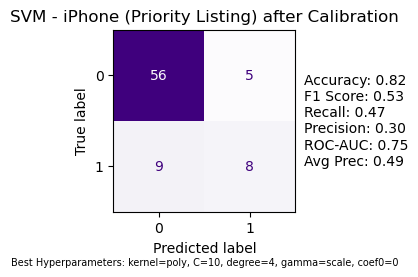

Predictions: (array([0, 1]), array([65, 13]))


In [16]:
calibrated_model_iphone = CalibratedClassifierCV(best_model_iphone, method='isotonic', cv=5)
calibrated_model_iphone.fit(X_train_scaled_iphone, y_train_iphone)
probs = calibrated_model_iphone.predict_proba(X_test_scaled_iphone)[:, 1]
thresholds = np.linspace(0, 1, 100)

f1_scores = [f1_score(y_test_iphone, probs > t) for t in thresholds]
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"Best threshold for F1: {best_thresh:.2f}")

y_pred_adjusted = (probs > best_thresh).astype(int)

accuracy = accuracy_score(y_test_iphone, y_pred_adjusted)
f1 = f1_score(y_test_iphone,  y_pred_adjusted)
recall = recall_score(y_test_iphone,  y_pred_adjusted)
roc_auc = roc_auc_score(y_test_iphone, probs)
avg_prec = average_precision_score(y_test_iphone, probs)

print("Test Accuracy:", accuracy)
print("Test F1", f1)
print("Test Recall", recall)
print("Test ROC AUC:", roc_auc)
print("Test Average Precision (AP):", avg_prec)

print(classification_report(y_test_iphone, y_pred_adjusted))
print(confusion_matrix(y_test_iphone, y_pred_adjusted))

cm_iphone = confusion_matrix(y_test_iphone, y_pred_adjusted)
fig, ax = plt.subplots(figsize=(5,3))
disp_iphone = ConfusionMatrixDisplay(confusion_matrix=cm_iphone, display_labels=calibrated_model_iphone.classes_)
disp_iphone = disp_iphone.plot(ax=ax, cmap="Purples", colorbar=False)
disp_iphone.ax_.set_title('SVM - iPhone (Priority Listing) after Calibration')
textstr = f'Accuracy: {accuracy:.2f}\nF1 Score: {f1:.2f}\nRecall: {recall:.2f}\nPrecision: {prec:.2f}\nROC-AUC: {roc_auc:.2f}\nAvg Prec: {avg_prec:.2f}'
ax.text(1.05, 0.5, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='center')
params = [f'kernel={best_model_iphone.kernel}', f'C={best_model_iphone.C}']
if hasattr(best_model_iphone, "degree") and best_model_iphone.kernel == "poly":
    params.append(f'degree={best_model_iphone.degree}')
if hasattr(best_model_iphone, "gamma") and best_model_iphone.kernel in ["rbf", "poly", "sigmoid"]:
    params.append(f'gamma={best_model_iphone.gamma}')
if hasattr(best_model_iphone, "coef0") and best_model_iphone.kernel in ["poly", "sigmoid"]:
    params.append(f'coef0={best_model_iphone.coef0}')
params_str = "Best Hyperparameters: " + ", ".join(params)
ax.text(0.5, -0.25, params_str, transform=ax.transAxes,
        fontsize=7, ha='center', va='top')
plt.tight_layout()
plt.savefig("images/4/cm_svm_iphone4.png", dpi=300, bbox_inches='tight')
plt.show()

print("Predictions:", np.unique(y_pred_adjusted, return_counts=True))

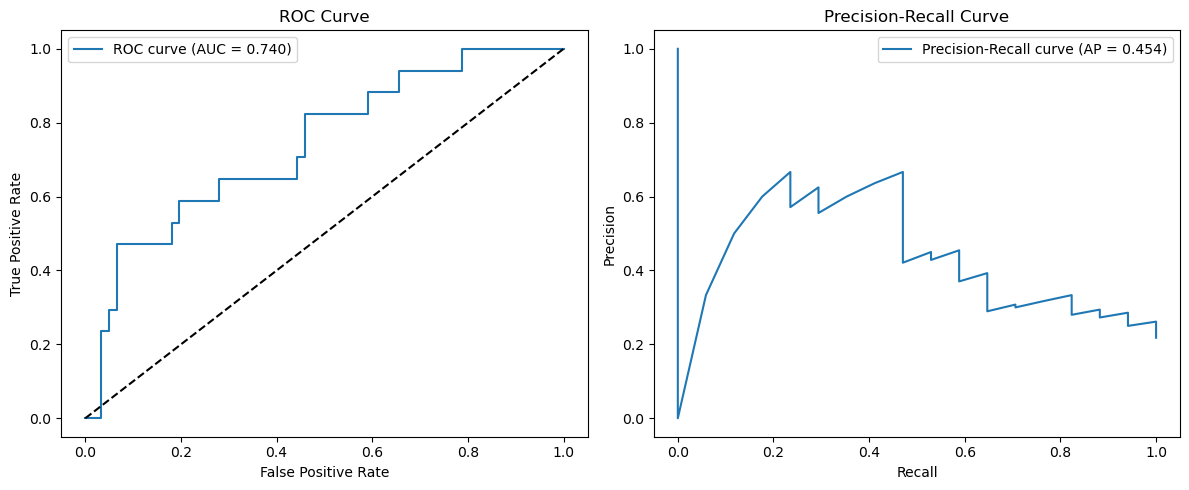

In [17]:
# Get predicted probabilities for the positive class
probs = best_model_iphone.predict_proba(X_test_scaled_iphone)[:, 1]

# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test_iphone, probs)
roc_auc = roc_auc_score(y_test_iphone, probs)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line for random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_test_iphone, probs)
avg_precision = average_precision_score(y_test_iphone, probs)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.tight_layout()
plt.show()


### Soccer

In [18]:
num_features_soccer = ["seller.feedbackPercentage", "seller.feedbackScore", "days_listed",  "seller_item_count",
                        "additional_image_count", "title_length"]
response = "is_high_price"

from sklearn.model_selection import train_test_split
X_train_soccer, X_test_soccer, y_train_soccer, y_test_soccer = train_test_split(df_soccer[num_features_soccer], df_soccer[response],
                                                               test_size=0.20, random_state=1216)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled_soccer = sc.fit_transform(X_train_soccer)
X_test_scaled_soccer = sc.transform(X_test_soccer)

In [19]:
params_grid = [{'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['linear']},
               {'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['rbf'], 'gamma': ['scale', 0.1, 1]},
               {'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['poly'], 'degree': [2, 3, 4], 
               'gamma': ['scale', 0.1, 1], 'coef0': [0, 1]}]

classifier_soccer = SVC(probability=True)
grid_search_soccer = GridSearchCV(estimator = classifier_soccer,
                           param_grid = params_grid,
                           scoring = 'accuracy', # accuracy is used as scoring metric
                           cv = 10,
                           n_jobs = -1)

grid_search_soccer.fit(X_train_scaled_soccer, y_train_soccer)

best_acc = grid_search_soccer.best_score_
best_parameters = grid_search_soccer.best_params_
print('Best CV Accuracy:', best_acc)
print('Best CV Parameters:', best_parameters)

results = pd.DataFrame(grid_search_soccer.cv_results_)
results_sorted = results.sort_values(by="mean_test_score", ascending=False)
print(results_sorted[["params", "mean_test_score"]].head(5))
results_sorted = results_sorted[["params", "mean_test_score"]].head(5)
results_sorted = results_sorted.rename(columns={
    "params": "SVM Parameters",
    "mean_test_score": "Mean CV Score"
})

html_table = results_sorted.to_html(index=False, escape=False)
print(html_table)

Best CV Accuracy: 0.73375
Best CV Parameters: {'C': 10, 'coef0': 1, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}
                                                params  mean_test_score
106  {'C': 10, 'coef0': 1, 'degree': 3, 'gamma': 1,...          0.73375
90   {'C': 5, 'coef0': 1, 'degree': 4, 'gamma': 0.1...          0.73125
108  {'C': 10, 'coef0': 1, 'degree': 4, 'gamma': 0....          0.73125
71   {'C': 1, 'coef0': 1, 'degree': 4, 'gamma': 'sc...          0.73125
105  {'C': 10, 'coef0': 1, 'degree': 3, 'gamma': 0....          0.72875
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>SVM Parameters</th>
      <th>Mean CV Score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>{'C': 10, 'coef0': 1, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}</td>
      <td>0.73375</td>
    </tr>
    <tr>
      <td>{'C': 5, 'coef0': 1, 'degree': 4, 'gamma': 0.1, 'kernel': 'poly'}</td>
      <td>0.73125</td>
    </tr>
    <tr>
      <td>{'C': 10, 'coef0': 1

Test accuracy
0.78


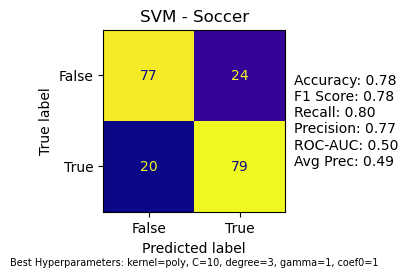

Predictions: (array([False,  True]), array([ 97, 103]))


In [20]:
best_model_soccer = grid_search_soccer.best_estimator_
preds_best_soccer = best_model_soccer.predict(X_test_scaled_soccer)
y_proba = best_model_soccer.predict_proba(X_test_scaled_soccer)[:,1]
accuracy = accuracy_score(y_test_soccer, preds_best_soccer)
print("Test accuracy")
print(accuracy)

accuracy = accuracy_score(y_test_soccer, preds_best_soccer)
f1 = f1_score(y_test_soccer,  preds_best_soccer)
recall = recall_score(y_test_soccer,  preds_best_soccer)
prec = precision_score(y_test_soccer, preds_best_soccer)
roc_auc = roc_auc_score(y_test_soccer, y_proba)
avg_prec = average_precision_score(y_test_soccer, y_proba)

cm_soccer = confusion_matrix(y_test_soccer,  preds_best_soccer)
fig, ax = plt.subplots(figsize=(5,3))
disp_soccer = ConfusionMatrixDisplay(confusion_matrix=cm_soccer, display_labels=best_model_soccer.classes_)
disp_soccer = disp_soccer.plot(ax=ax, cmap="plasma", colorbar=False)
disp_soccer.ax_.set_title('SVM - Soccer')
textstr = f'Accuracy: {accuracy:.2f}\nF1 Score: {f1:.2f}\nRecall: {recall:.2f}\nPrecision: {prec:.2f}\nROC-AUC: {roc_auc:.2f}\nAvg Prec: {avg_prec:.2f}'

ax.text(1.05, 0.5, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='center')
params = [f'kernel={best_model_soccer.kernel}', f'C={best_model_soccer.C}']
if hasattr(best_model_soccer, "degree") and best_model_soccer.kernel == "poly":
    params.append(f'degree={best_model_soccer.degree}')
if hasattr(best_model_soccer, "gamma") and best_model_soccer.kernel in ["rbf", "poly", "sigmoid"]:
    params.append(f'gamma={best_model_soccer.gamma}')
if hasattr(best_model_soccer, "coef0") and best_model_soccer.kernel in ["poly", "sigmoid"]:
    params.append(f'coef0={best_model_soccer.coef0}')
params_str = "Best Hyperparameters: " + ", ".join(params)
ax.text(0.5, -0.25, params_str, transform=ax.transAxes,
        fontsize=7, ha='center', va='top')
plt.tight_layout()
plt.savefig("images/4/cm_svm_soccer.png", dpi=300, bbox_inches='tight')
plt.show()

print("Predictions:", np.unique(preds_best_soccer, return_counts=True))

In [21]:
print("True y")
print(np.unique(y_test_soccer, return_counts=True), "\n")
print("Predicted y")
print(np.unique(preds_best_soccer, return_counts=True))

true_labels, true_counts = np.unique(y_test_soccer, return_counts=True)
pred_labels, pred_counts = np.unique(preds_best_soccer, return_counts=True)

df_counts = pd.DataFrame({
    "True Label": pd.Series(true_counts, index=true_labels),
    "Predicted Label": pd.Series(pred_counts, index=pred_labels)
}).fillna(0).astype(int)

html_table = df_counts.to_html(border=0, index=True)
print(html_table)

True y
(array([False,  True]), array([101,  99])) 

Predicted y
(array([False,  True]), array([ 97, 103]))
<table class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>True Label</th>
      <th>Predicted Label</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>False</th>
      <td>101</td>
      <td>97</td>
    </tr>
    <tr>
      <th>True</th>
      <td>99</td>
      <td>103</td>
    </tr>
  </tbody>
</table>


In [22]:
from sklearn.inspection import permutation_importance
result = permutation_importance(best_model_soccer, X_test_scaled_soccer, y_test_soccer, 
                                n_repeats=10, random_state=1216, scoring='accuracy')
importance_means = result.importances_mean
importance_std = result.importances_std

for i, col in enumerate(num_features_soccer):
    print(f"{col}: Mean importance = {importance_means[i]:.4f}, Std = {importance_std[i]:.4f}")


seller.feedbackPercentage: Mean importance = 0.0230, Std = 0.0081
seller.feedbackScore: Mean importance = 0.0610, Std = 0.0124
days_listed: Mean importance = 0.0430, Std = 0.0201
seller_item_count: Mean importance = 0.0600, Std = 0.0210
additional_image_count: Mean importance = 0.1325, Std = 0.0206
title_length: Mean importance = 0.0700, Std = 0.0210


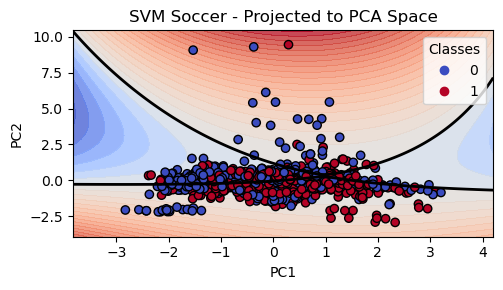

In [23]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled_soccer)
X_test_pca = pca.transform(X_test_scaled_soccer)

plot_svm_decision_boundary_pca(best_model_soccer, 
                               X_train_scaled_soccer, 
                               X_train_pca, 
                               y_train_soccer.values, 
                               pca, 
                               ['PC1', 'PC2'], 
                               "SVM Soccer - Projected to PCA Space", 
                               "svm_boundary_soccer")

Text(0.5, 1.0, 'Decision Function Distribution')

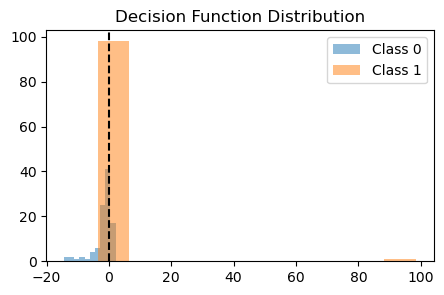

In [24]:
decisions = best_model_soccer.decision_function(X_test_scaled_soccer)
plt.figure(figsize=(5,3))
plt.hist(decisions[y_test_soccer==0], alpha=0.5, label='Class 0')
plt.hist(decisions[y_test_soccer==1], alpha=0.5, label='Class 1')
plt.axvline(0, color='k', linestyle='--')
plt.legend()
plt.title("Decision Function Distribution")


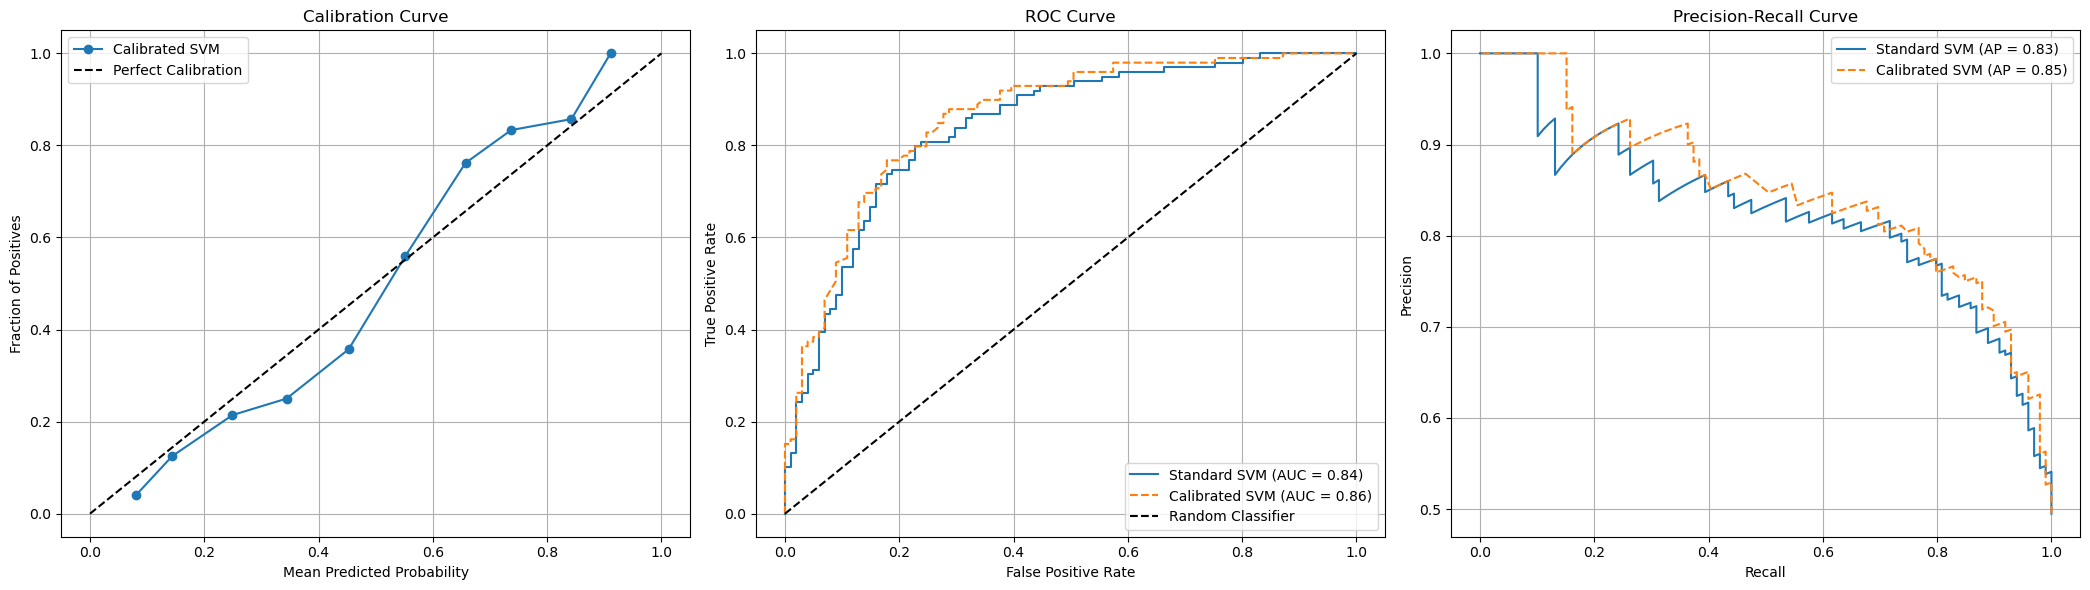

In [25]:
# Calibrate the best model
calibrated_model_soccer = CalibratedClassifierCV(best_model_soccer, method='isotonic', cv=5)
calibrated_model_soccer.fit(X_train_scaled_soccer, y_train_soccer)

# Get decision function and predicted probabilities
y_scores_std = best_model_soccer.decision_function(X_test_scaled_soccer)
y_probs_cal = calibrated_model_soccer.predict_proba(X_test_scaled_soccer)[:, 1]

# === CALIBRATION CURVE ===
prob_true, prob_pred = calibration_curve(y_test_soccer, y_probs_cal, n_bins=10)

# === ROC CURVE ===
auc_std = roc_auc_score(y_test_soccer, y_scores_std)
auc_cal = roc_auc_score(y_test_soccer, y_probs_cal)
fpr_std, tpr_std, _ = roc_curve(y_test_soccer, y_scores_std)
fpr_cal, tpr_cal, _ = roc_curve(y_test_soccer, y_probs_cal)

# === PRECISION-RECALL CURVE ===
precision_std, recall_std, _ = precision_recall_curve(y_test_soccer, y_scores_std)
avg_precision_std = average_precision_score(y_test_soccer, y_scores_std)

precision_cal, recall_cal, _ = precision_recall_curve(y_test_soccer, y_probs_cal)
avg_precision_cal = average_precision_score(y_test_soccer, y_probs_cal)

# === PLOTTING ===
fig, axs = plt.subplots(1, 3, figsize=(21, 6))

# 1. Calibration Curve
axs[0].plot(prob_pred, prob_true, marker='o', label="Calibrated SVM")
axs[0].plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
axs[0].set_xlabel("Mean Predicted Probability")
axs[0].set_ylabel("Fraction of Positives")
axs[0].set_title("Calibration Curve")
axs[0].legend()
axs[0].grid(True)

# 2. ROC Curve
axs[1].plot(fpr_std, tpr_std, label=f"Standard SVM (AUC = {auc_std:.2f})")
axs[1].plot(fpr_cal, tpr_cal, label=f"Calibrated SVM (AUC = {auc_cal:.2f})", linestyle='--')
axs[1].plot([0, 1], [0, 1], 'k--', label="Random Classifier")
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")
axs[1].set_title("ROC Curve")
axs[1].legend()
axs[1].grid(True)

# 3. Precision-Recall Curve
axs[2].plot(recall_std, precision_std, label=f"Standard SVM (AP = {avg_precision_std:.2f})")
axs[2].plot(recall_cal, precision_cal, label=f"Calibrated SVM (AP = {avg_precision_cal:.2f})", linestyle='--')
axs[2].set_xlabel("Recall")
axs[2].set_ylabel("Precision")
axs[2].set_title("Precision-Recall Curve")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.savefig("images/4/calibration_roc_pr_soccer.png", dpi=300, bbox_inches='tight')
plt.show()

Best threshold for F1: 0.45
              precision    recall  f1-score   support

       False       0.86      0.71      0.78       101
        True       0.75      0.88      0.81        99

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.79       200
weighted avg       0.80      0.80      0.79       200

[[72 29]
 [12 87]]


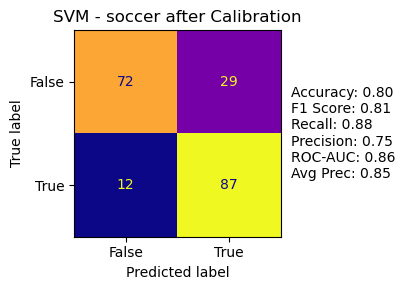

Predictions: (array([0, 1]), array([ 84, 116]))


In [26]:
probs = calibrated_model_soccer.predict_proba(X_test_scaled_soccer)[:, 1]
thresholds = np.linspace(0, 1, 100)
f1_scores = [f1_score(y_test_soccer, probs > t) for t in thresholds]
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"Best threshold for F1: {best_thresh:.2f}")

y_pred_adjusted = (probs > best_thresh).astype(int)


print(classification_report(y_test_soccer, y_pred_adjusted))
print(confusion_matrix(y_test_soccer, y_pred_adjusted))

accuracy = accuracy_score(y_test_soccer, y_pred_adjusted)
f1 = f1_score(y_test_soccer,  y_pred_adjusted)
recall = recall_score(y_test_soccer,  y_pred_adjusted)
prec = precision_score(y_test_soccer, y_pred_adjusted)
roc_auc = roc_auc_score(y_test_soccer, probs)
avg_prec = average_precision_score(y_test_soccer, probs)

cm_soccer = confusion_matrix(y_test_soccer,  y_pred_adjusted)
fig, ax = plt.subplots(figsize=(5,3))
disp_soccer = ConfusionMatrixDisplay(confusion_matrix=cm_soccer, display_labels=calibrated_model_soccer.classes_)
disp_soccer = disp_soccer.plot(ax=ax, cmap="plasma", colorbar=False)
disp_soccer.ax_.set_title('SVM - soccer after Calibration')
textstr = f'Accuracy: {accuracy:.2f}\nF1 Score: {f1:.2f}\nRecall: {recall:.2f}\nPrecision: {prec:.2f}\nROC-AUC: {roc_auc:.2f}\nAvg Prec: {avg_prec:.2f}'

ax.text(1.05, 0.5, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='center')
plt.tight_layout()
plt.savefig("images/4/cm_svm_soccer2.png", dpi=300, bbox_inches='tight')
plt.show()

print("Predictions:", np.unique(y_pred_adjusted, return_counts=True))

### Lego

#### price classification

In [27]:
num_features_lego = ["rating", "ratings_total", "recent_sales_num", "discount$", "discount%"]
df_lego[num_features_lego] = df_lego[num_features_lego].fillna(0)
response = "is_high_price"

from sklearn.model_selection import train_test_split
X_train_lego, X_test_lego, y_train_lego, y_test_lego = train_test_split(df_lego[num_features_lego], df_lego[response],
                                                               test_size=0.20, random_state=1216)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled_lego = sc.fit_transform(X_train_lego)
X_test_scaled_lego = sc.transform(X_test_lego)

In [28]:
params_grid = [{'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['linear']},
               {'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['rbf'], 'gamma': ['scale', 0.1, 1]},
               {'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['poly'], 'degree': [2, 3, 4], 
               'gamma': ['scale', 0.1, 1], 'coef0': [0, 1]}]

classifier_lego = SVC(probability=True)
grid_search_lego = GridSearchCV(estimator = classifier_lego,
                           param_grid = params_grid,
                           scoring = 'accuracy', # accuracy is used as scoring metric
                           cv = 10,
                           n_jobs = -1)

grid_search_lego.fit(X_train_scaled_lego, y_train_lego)

best_acc = grid_search_lego.best_score_
best_parameters = grid_search_lego.best_params_
print('Best CV Accuracy:', best_acc)
print('Best CV Parameters:', best_parameters)

results = pd.DataFrame(grid_search_lego.cv_results_)
results_sorted = results.sort_values(by="mean_test_score", ascending=False)
print(results_sorted[["params", "mean_test_score"]].head(5))
results_sorted = results_sorted[["params", "mean_test_score"]].head(5)
results_sorted = results_sorted.rename(columns={
    "params": "SVM Parameters",
    "mean_test_score": "Mean CV Score"
})

html_table = results_sorted.to_html(index=False, escape=False)
print(html_table)

Best CV Accuracy: 0.8633333333333335
Best CV Parameters: {'C': 10, 'coef0': 1, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}
                                                params  mean_test_score
103  {'C': 10, 'coef0': 1, 'degree': 2, 'gamma': 1,...         0.863333
97   {'C': 10, 'coef0': 0, 'degree': 3, 'gamma': 1,...         0.855833
70   {'C': 1, 'coef0': 1, 'degree': 3, 'gamma': 1, ...         0.855417
104  {'C': 10, 'coef0': 1, 'degree': 3, 'gamma': 's...         0.849583
106  {'C': 10, 'coef0': 1, 'degree': 3, 'gamma': 1,...         0.849167
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>SVM Parameters</th>
      <th>Mean CV Score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>{'C': 10, 'coef0': 1, 'degree': 2, 'gamma': 1, 'kernel': 'poly'}</td>
      <td>0.863333</td>
    </tr>
    <tr>
      <td>{'C': 10, 'coef0': 0, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}</td>
      <td>0.855833</td>
    </tr>
    <tr>
      <td>{'C': 1,

Test accuracy
0.8421052631578947


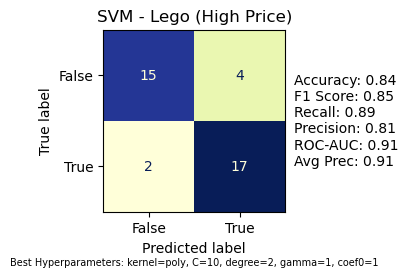

Predictions: (array([False,  True]), array([17, 21]))


In [29]:
best_model_lego = grid_search_lego.best_estimator_
preds_best_lego = best_model_lego.predict(X_test_scaled_lego)
y_proba = best_model_lego.predict_proba(X_test_scaled_lego)[:,1]
accuracy = accuracy_score(y_test_lego, preds_best_lego)
print("Test accuracy")
print(accuracy)

accuracy = accuracy_score(y_test_lego, preds_best_lego)
f1 = f1_score(y_test_lego,  preds_best_lego)
recall = recall_score(y_test_lego,  preds_best_lego)
prec = precision_score(y_test_lego, preds_best_lego)
roc_auc = roc_auc_score(y_test_lego, y_proba)
avg_prec = average_precision_score(y_test_lego, y_proba)
cm_lego = confusion_matrix(y_test_lego,  preds_best_lego)
fig, ax = plt.subplots(figsize=(5,3))
disp_lego = ConfusionMatrixDisplay(confusion_matrix=cm_lego, display_labels=best_model_lego.classes_)
disp_lego = disp_lego.plot(ax=ax, cmap="YlGnBu", colorbar=False)
disp_lego.ax_.set_title('SVM - Lego (High Price)')
textstr = f'Accuracy: {accuracy:.2f}\nF1 Score: {f1:.2f}\nRecall: {recall:.2f}\nPrecision: {prec:.2f}\nROC-AUC: {roc_auc:.2f}\nAvg Prec: {avg_prec:.2f}'
ax.text(1.05, 0.5, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='center')
params = [f'kernel={best_model_lego.kernel}', f'C={best_model_lego.C}']
if hasattr(best_model_lego, "degree") and best_model_lego.kernel == "poly":
    params.append(f'degree={best_model_lego.degree}')
if hasattr(best_model_lego, "gamma") and best_model_lego.kernel in ["rbf", "poly", "sigmoid"]:
    params.append(f'gamma={best_model_lego.gamma}')
if hasattr(best_model_lego, "coef0") and best_model_lego.kernel in ["poly", "sigmoid"]:
    params.append(f'coef0={best_model_lego.coef0}')
params_str = "Best Hyperparameters: " + ", ".join(params)
ax.text(0.5, -0.25, params_str, transform=ax.transAxes,
        fontsize=7, ha='center', va='top')
plt.tight_layout()
plt.savefig("images/4/cm_svm_lego.png", dpi=300, bbox_inches='tight')
plt.show()

print("Predictions:", np.unique(preds_best_lego, return_counts=True))

In [30]:
print("True y")
print(np.unique(y_test_lego, return_counts=True), "\n")
print("Predicted y")
print(np.unique(preds_best_lego, return_counts=True))

true_labels, true_counts = np.unique(y_test_iphone, return_counts=True)
pred_labels, pred_counts = np.unique(preds_best_iphone, return_counts=True)

df_counts = pd.DataFrame({
    "True Label": pd.Series(true_counts, index=true_labels),
    "Predicted Label": pd.Series(pred_counts, index=pred_labels)
}).fillna(0).astype(int)

html_table = df_counts.to_html(border=0, index=True)
print(html_table)

True y
(array([False,  True]), array([19, 19])) 

Predicted y
(array([False,  True]), array([17, 21]))
<table class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>True Label</th>
      <th>Predicted Label</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>61</td>
      <td>33</td>
    </tr>
    <tr>
      <th>1</th>
      <td>17</td>
      <td>45</td>
    </tr>
  </tbody>
</table>


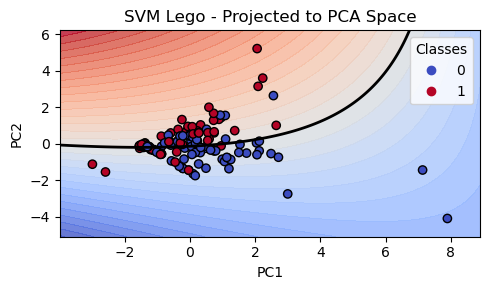

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import TwoSlopeNorm
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled_lego)
X_test_pca = pca.transform(X_test_scaled_lego)

plot_svm_decision_boundary_pca(best_model_lego, 
                               X_train_scaled_lego, 
                               X_train_pca, 
                               y_train_lego.values, 
                               pca, 
                               ['PC1', 'PC2'], 
                               "SVM Lego - Projected to PCA Space", 
                               "svm_boundary_lego")

#### top theme class

In [32]:
num_features_lego = ["rating", "ratings_total", "recent_sales_num", "discount$", "discount%", "price_value"]
df_lego[num_features_lego] = df_lego[num_features_lego].fillna(0)
response = "top_theme"

from sklearn.model_selection import train_test_split
X_train_lego, X_test_lego, y_train_lego, y_test_lego = train_test_split(df_lego[num_features_lego], df_lego[response],
                                                               test_size=0.20, random_state=1216)

print(np.unique(y_train_lego, return_counts=True))
print(np.unique(y_test_lego, return_counts=True))

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled_lego = sc.fit_transform(X_train_lego)
X_test_scaled_lego = sc.transform(X_test_lego)

params_grid = [{'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['linear']},
               {'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['rbf'], 'gamma': ['scale', 0.1, 1]},
               {'C': [0.1, 0.5, 1, 5, 10], 'kernel': ['poly'], 'degree': [2, 3, 4], 
               'gamma': ['scale', 0.1, 1], 'coef0': [0, 1]}]

scoring = "balanced_accuracy"
classifier_lego = SVC(class_weight="balanced", probability=True)
grid_search_lego = GridSearchCV(estimator = classifier_lego,
                           param_grid = params_grid,
                           scoring = scoring, 
                           cv = 10,
                           n_jobs = -1)

grid_search_lego.fit(X_train_scaled_lego, y_train_lego)

best_scoring = grid_search_lego.best_score_
best_parameters = grid_search_lego.best_params_
print('Best CV Scoring:', best_scoring)
print('Best CV Parameters:', best_parameters)

results = pd.DataFrame(grid_search_lego.cv_results_)
results_sorted = results.sort_values(by="mean_test_score", ascending=False)
print(results_sorted[["params", "mean_test_score"]].head(5))

best_model_lego = grid_search_lego.best_estimator_

(array([False,  True]), array([ 31, 121]))
(array([False,  True]), array([ 9, 29]))
Best CV Scoring: 0.6961538461538461
Best CV Parameters: {'C': 1, 'coef0': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
                                               params  mean_test_score
65  {'C': 1, 'coef0': 1, 'degree': 2, 'gamma': 'sc...         0.696154
66  {'C': 1, 'coef0': 1, 'degree': 2, 'gamma': 0.1...         0.691987
51  {'C': 0.5, 'coef0': 1, 'degree': 3, 'gamma': 0...         0.679487
47  {'C': 0.5, 'coef0': 1, 'degree': 2, 'gamma': '...         0.679487
95  {'C': 10, 'coef0': 0, 'degree': 3, 'gamma': 's...         0.675321


Test Accuracy: 0.6578947368421053
Test F1 0.7719298245614035
Test Recall 0.7586206896551724
Test Precision 0.7857142857142857
Test ROC AUC: 0.5134099616858239
Test Average Precision (AP): 0.7774860114797777
              precision    recall  f1-score   support

       False       0.30      0.33      0.32         9
        True       0.79      0.76      0.77        29

    accuracy                           0.66        38
   macro avg       0.54      0.55      0.54        38
weighted avg       0.67      0.66      0.66        38

[[ 3  6]
 [ 7 22]]


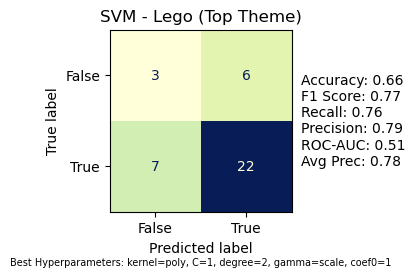

Predictions: (array([False,  True]), array([17, 21]))


In [33]:
y_pred = best_model_lego.predict(X_test_scaled_lego)
y_proba = best_model_lego.predict_proba(X_test_scaled_lego)[:,1]
accuracy = accuracy_score(y_test_lego, y_pred)
f1 = f1_score(y_test_lego,  y_pred)
recall = recall_score(y_test_lego,  y_pred)
prec = precision_score(y_test_lego, y_pred)
roc_auc = roc_auc_score(y_test_lego, y_proba)
avg_prec = average_precision_score(y_test_lego, y_proba)

print("Test Accuracy:", accuracy)
print("Test F1", f1)
print("Test Recall", recall)
print("Test Precision", prec)
print("Test ROC AUC:", roc_auc)
print("Test Average Precision (AP):", avg_prec)

print(classification_report(y_test_lego, y_pred))
print(confusion_matrix(y_test_lego, y_pred))

cm_lego = confusion_matrix(y_test_lego, y_pred)
fig, ax = plt.subplots(figsize=(5,3))
disp_lego = ConfusionMatrixDisplay(confusion_matrix=cm_lego, display_labels=best_model_lego.classes_)
disp_lego = disp_lego.plot(ax=ax, cmap="YlGnBu", colorbar=False)
disp_lego.ax_.set_title('SVM - Lego (Top Theme)')

textstr = f'Accuracy: {accuracy:.2f}\nF1 Score: {f1:.2f}\nRecall: {recall:.2f}\nPrecision: {prec:.2f}\nROC-AUC: {roc_auc:.2f}\nAvg Prec: {avg_prec:.2f}'
ax.text(1.05, 0.5, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='center')

params = [f'kernel={best_model_lego.kernel}', f'C={best_model_lego.C}']
if hasattr(best_model_lego, "degree") and best_model_lego.kernel == "poly":
    params.append(f'degree={best_model_lego.degree}')
if hasattr(best_model_lego, "gamma") and best_model_lego.kernel in ["rbf", "poly", "sigmoid"]:
    params.append(f'gamma={best_model_lego.gamma}')
if hasattr(best_model_lego, "coef0") and best_model_lego.kernel in ["poly", "sigmoid"]:
    params.append(f'coef0={best_model_lego.coef0}')
params_str = "Best Hyperparameters: " + ", ".join(params)
ax.text(0.5, -0.25, params_str, transform=ax.transAxes,
        fontsize=7, ha='center', va='top')
plt.tight_layout()
plt.savefig("images/4/cm_svm_lego2.png", dpi=300, bbox_inches='tight')
plt.show()

print("Predictions:", np.unique(preds_best_lego, return_counts=True))

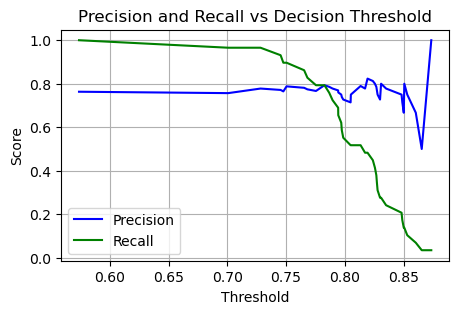

Best threshold by F1: 0.5738
Precision: 0.7632, Recall: 1.0000, F1: 0.8657


In [34]:


prec, rec, thresh = precision_recall_curve(y_test_lego, y_proba)
# Plot Precision and Recall vs Threshold
plt.figure(figsize=(5, 3))
plt.plot(thresh, prec[:-1], label='Precision', color='b')
plt.plot(thresh, rec[:-1], label='Recall', color='g')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Decision Threshold')
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import f1_score

f1_scores = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-10)
best_idx = f1_scores.argmax()
best_thresh = thresh[best_idx]
print(f"Best threshold by F1: {best_thresh:.4f}")
print(f"Precision: {prec[best_idx]:.4f}, Recall: {rec[best_idx]:.4f}, F1: {f1_scores[best_idx]:.4f}")

### SVM general

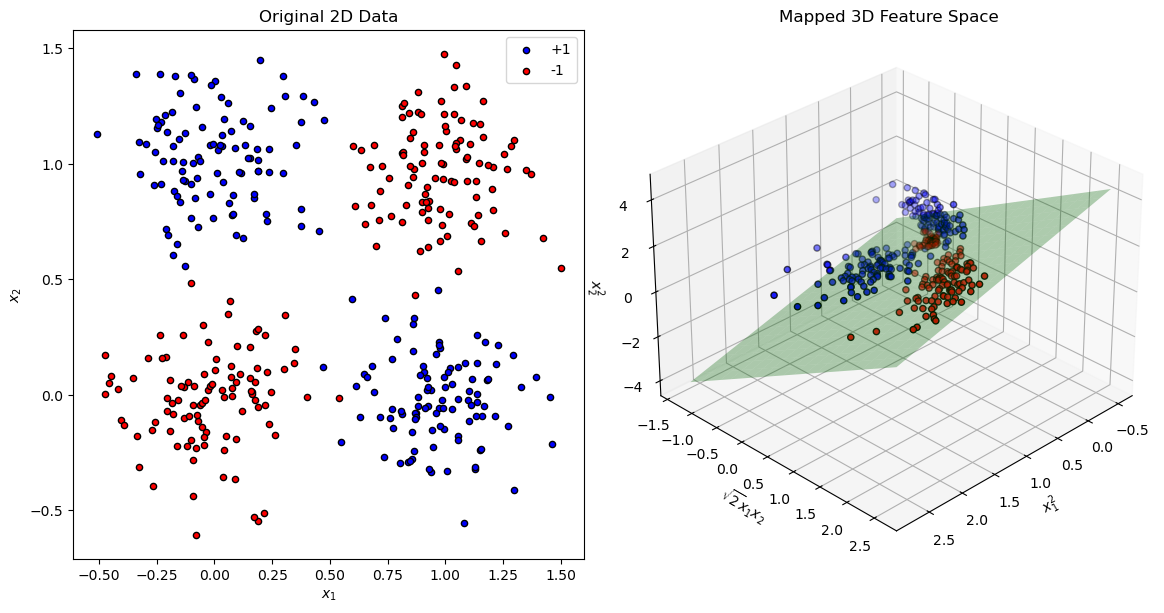

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVC, LinearSVC

# Generate more points for XOR-like data
np.random.seed(0)
n_points = 200

# Class +1 around (0,1) and (1,0)
class1 = np.vstack([
    np.random.randn(n_points // 2, 2) * 0.2 + [0, 1],
    np.random.randn(n_points // 2, 2) * 0.2 + [1, 0]
])

# Class -1 around (0,0) and (1,1)
class2 = np.vstack([
    np.random.randn(n_points // 2, 2) * 0.2 + [0, 0],
    np.random.randn(n_points // 2, 2) * 0.2 + [1, 1]
])

X = np.vstack([class1, class2])
y = np.hstack([np.ones(n_points), -np.ones(n_points)])

# Explicit polynomial mapping degree 2
def phi(X):
    X = np.atleast_2d(X)
    x1 = X[:, 0]
    x2 = X[:, 1]
    return np.column_stack([x1**2, np.sqrt(2)*x1*x2, x2**2])

X_mapped = phi(X)

# Train kernel SVM on original data
clf_kernel = SVC(kernel='poly', degree=2, coef0=0, C=1e6)
clf_kernel.fit(X, y)

# Train linear SVM on mapped data
clf_linear = LinearSVC(C=1e6, tol=1e-10, max_iter=10000)
clf_linear.fit(X_mapped, y)

# Plotting
fig = plt.figure(figsize=(12, 6))

# 1. Original 2D points
ax0 = fig.add_subplot(1, 2, 1)
ax0.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='+1', edgecolors='k', s=20)
ax0.scatter(X[y == -1, 0], X[y == -1, 1], c='red', label='-1', edgecolors='k', s=20)
ax0.set_title("Original 2D Data")
ax0.set_xlabel("$x_1$")
ax0.set_ylabel("$x_2$")
ax0.legend()
ax0.set_aspect('equal')

# 2. Mapped 3D points and linear decision boundary
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(X_mapped[y == 1, 0], X_mapped[y == 1, 1], X_mapped[y == 1, 2], c='blue', edgecolors='k', s=20)
ax2.scatter(X_mapped[y == -1, 0], X_mapped[y == -1, 1], X_mapped[y == -1, 2], c='red', edgecolors='k', s=20)
ax2.set_title("Mapped 3D Feature Space")
ax2.set_xlabel("$x_1^2$")
ax2.set_ylabel("$\sqrt{2} x_1 x_2$")
ax2.set_zlabel("$x_2^2$")
ax2.view_init(elev=30, azim=45)

# Linear decision boundary plane in 3D
w = clf_linear.coef_[0]
b = clf_linear.intercept_[0]

xx3, yy3 = np.meshgrid(
    np.linspace(X_mapped[:, 0].min() - 0.5, X_mapped[:, 0].max() + 0.5, 20),
    np.linspace(X_mapped[:, 1].min() - 0.5, X_mapped[:, 1].max() + 0.5, 20),
)
zz3 = (-w[0] * xx3 - w[1] * yy3 - b) / w[2]
ax2.plot_surface(xx3, yy3, zz3, color='green', alpha=0.3)

plt.tight_layout()
plt.savefig("images/4/svm_ex.png", dpi=300, bbox_inches='tight')
plt.show()


$K(x, y) = (x \cdot y)^2 = (x_1y_1 + x_2y_2)^2 = x_1^2y_1^2 + 2x_1x_2y_1y_2 + x_2^2y_2^2$

$\phi(x) = (x_1^2, \sqrt{2}x_1x_2, x_2^2)$
